### 6.3. Leverage the work from the MATLAB community

MATLAB has a vibrant and established community. It is actually quite complementary to the Python community, that is younger and growing fast in particular in areas related to Machine/Deep Learning. [MATLAB File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/) enables you to share your own files or browse and download files contributed by other users. It does not require you to use source control with Git, but can be connected with your code repositories on GitHub if you want to. This enables to access community contributions directly from MATLAB via the add-on manager. 

In this example, we will use a MATLAB community toolbox to fit a sine function over weather data.

#### Set-up the environment

In [ ]:
!git clone https://github.com/hgorr/weather-matlab-python

In [7]:
# download the zip file and unzip it
url_zip = 'https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/a1ca242b-82c2-4a89-b280-38d2243276da/4d399976-e76f-418a-a227-c97d2f7a85f7/packages/zip'

import requests, zipfile, io, os
r = requests.get(url_zip)
z = zipfile.ZipFile(io.BytesIO(r.content))
os.makedirs('sineFit', exist_ok=True)
z.extractall('sineFit')

#### Retrieve weather data

In [1]:
import os
os.chdir('weather-matlab-python')

We will use the sample dataset from the forecast in Munich.

In [2]:
import weather
appid ='b1b15e88fa797225412429c1c50c122a1'
json_data = weather.get_forecast('Muenchen','DE',appid,api='samples')
data = weather.parse_forecast_json(json_data)

The MATLAB engine is going to start in the current directory of the Python interpreter.

In [13]:
import matlab.engine
m = matlab.engine.connect_matlab()

In [15]:
m.pwd()

'C:\\Users\\ydebray\\Downloads\\python-book-github\\code\\weather-matlab-python'

In [14]:
m.desktop(nargout=0)

Let’s convert the data into MATLAB datatypes (datetime and double precision floats).

In [15]:
dt = m.datetime(data['current_time'])
temp = matlab.double(data['temp'])
m.plot(dt,temp)
m.print(m.tempdir()+"myPlot.png",'-dpng','-r300',nargout=0)

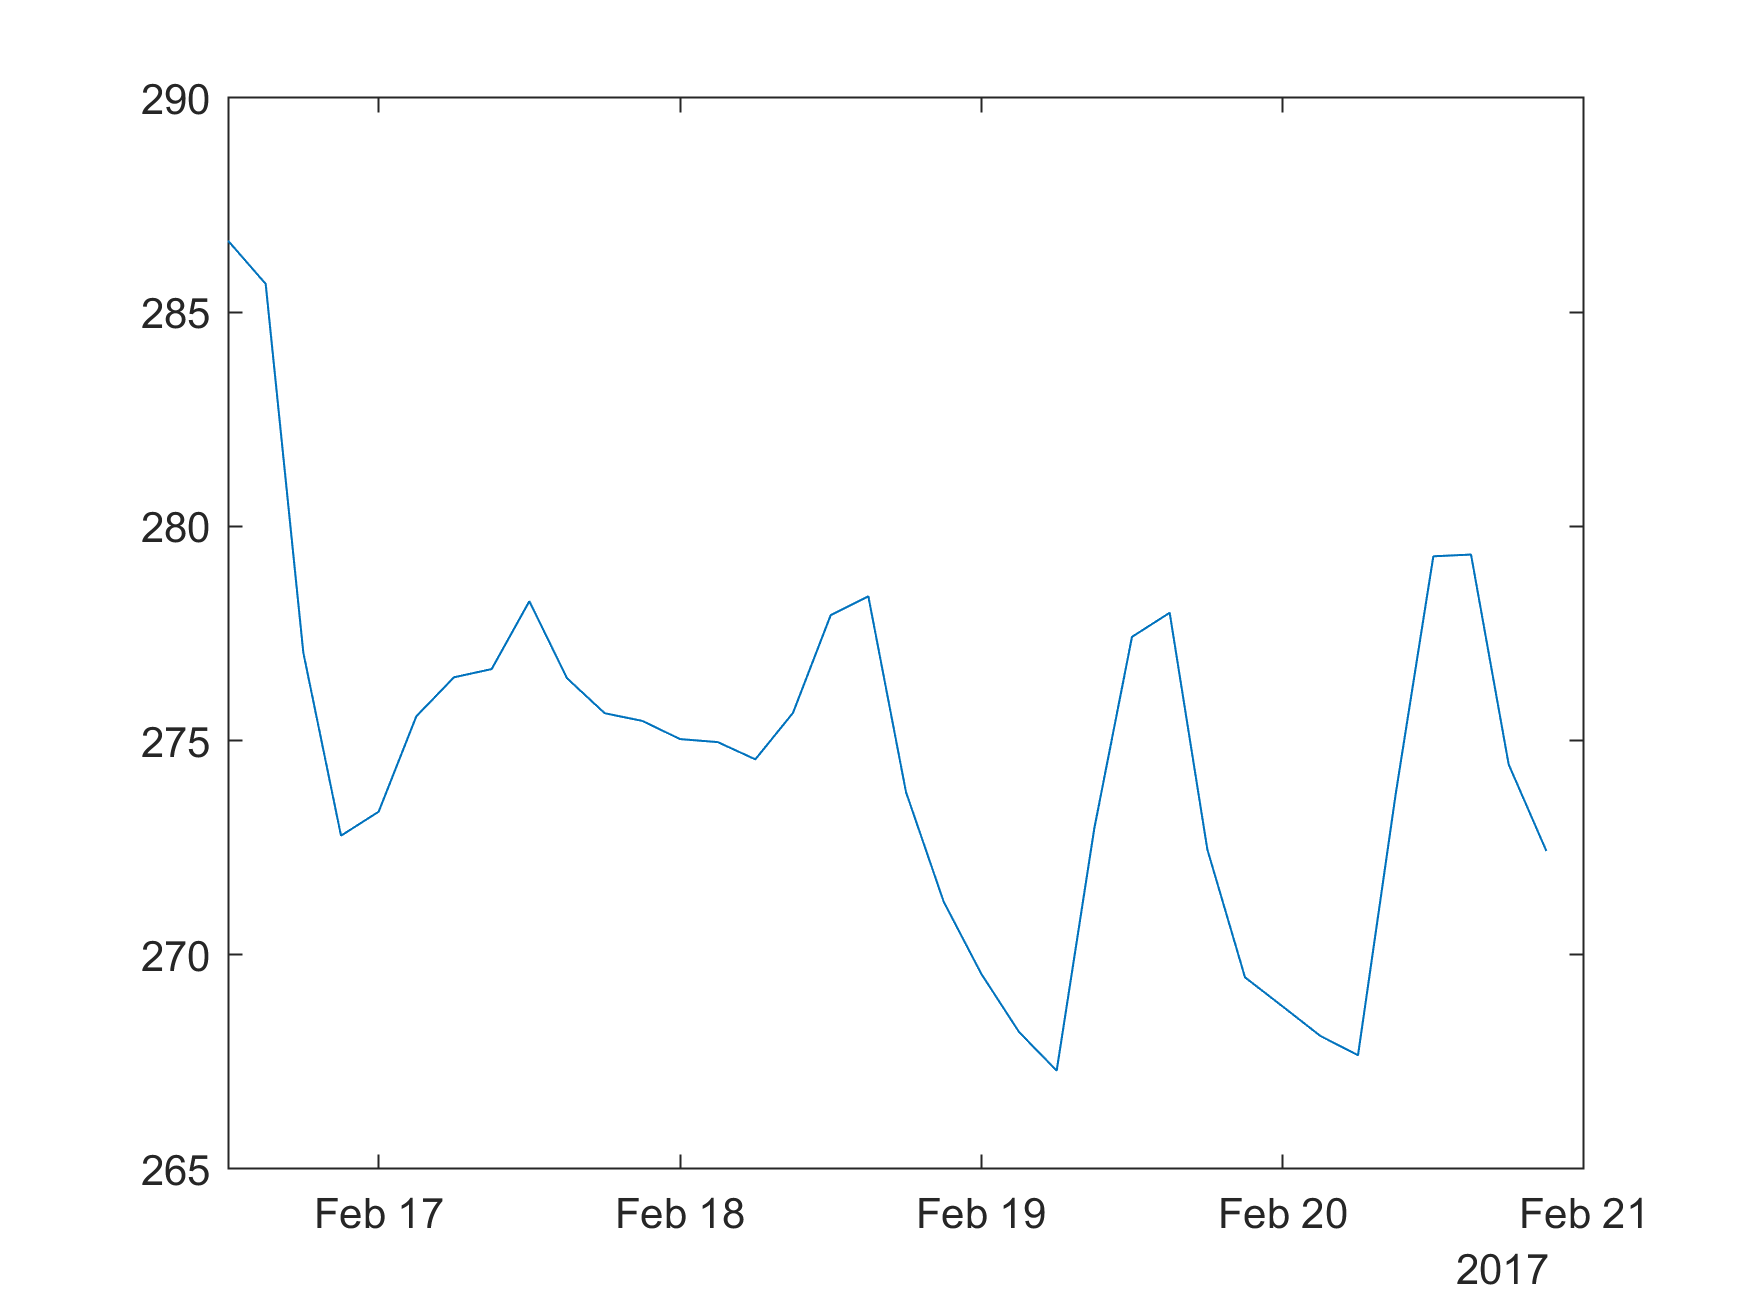

In [16]:
from IPython.display import Image
Image(m.tempdir()+"myPlot.png")

You can create a function to simplify the process of saving MATLAB plots in your notebook.

In [17]:
from IPython.display import Image
def mplot(x,y):
    m.plot(x,y)
    m.print(m.tempdir()+"myPlot.png",'-dpng','-r300',nargout=0)
    return Image(m.tempdir()+"myPlot.png")
# mplot(dt,temp)

#### Sine Fitting

In [24]:
# Retrieve description from the webpage https://www.mathworks.com/matlabcentral/fileexchange/66793-sine-fitting
import requests
from bs4 import BeautifulSoup
from IPython.display import HTML
url = 'https://www.mathworks.com/matlabcentral/fileexchange/66793-sine-fitting'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
description = soup.find('div', id='description')#.get_text()
HTML(str(description))

In [18]:
m.cd('..')
m.cd('sineFit/')


'C:\\Users\\ydebray\\Downloads\\python-book-github\\code'

In [61]:
t = matlab.double(range(36))
SineParams = m.sineFit(t,temp)
SineParams

matlab.double([[274.51842044220115,4.390270295890297,0.12378139169121775,1.3187000578012196,9.61367024285807]])

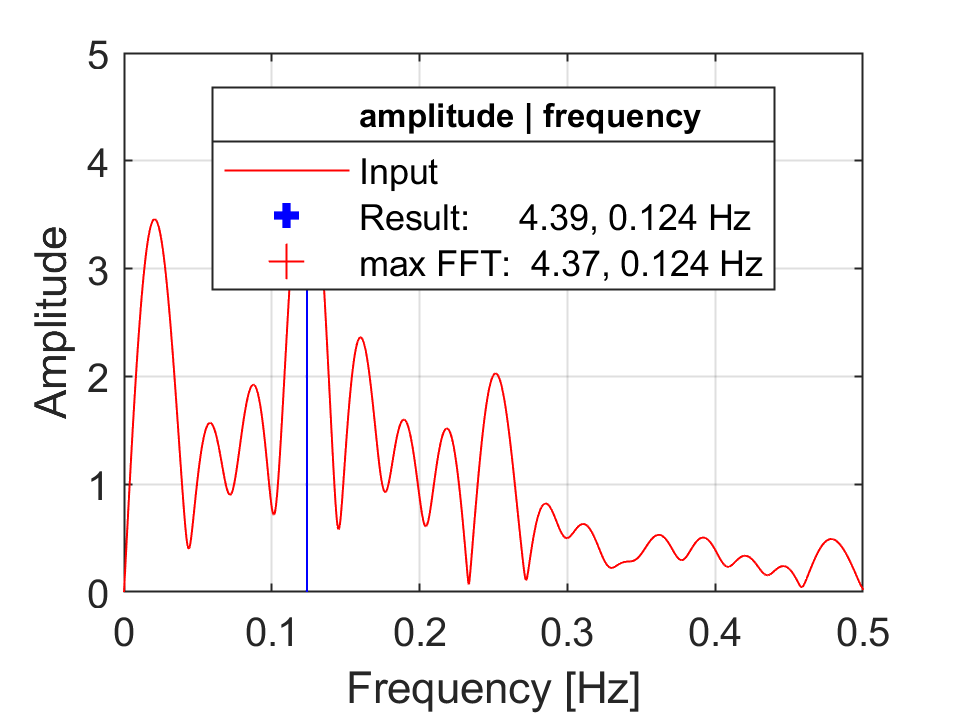

In [62]:
m.print(m.tempdir()+"fft.png",'-dpng','-r300',nargout=0)
m.close(m.gcf()) # close the current figure
Image(m.tempdir()+"fft.png")

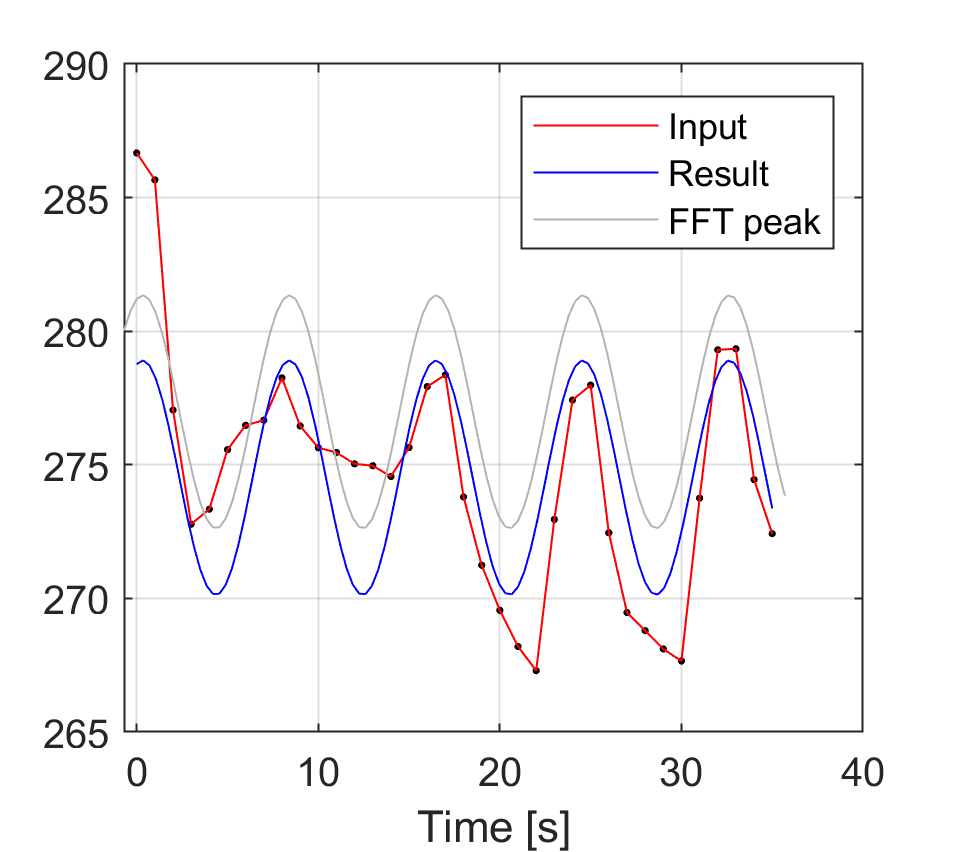

In [63]:
m.print(m.tempdir()+"sine.png",'-dpng','-r300',nargout=0)
m.close(m.gcf())
Image(m.tempdir()+"sine.png")

#### Sine Fit 2: retrieve the values of the sine model
Create a function in MATLAB that returns the values of the sine model for a given set of parameters and a given set of x values.

In [66]:
m.edit('sineFit2.m',nargout=0)

```matlab
function Sine=sineFit2(y)
    s = size(y);
    if s(1)>s(2)
        y = y';
    end
    n=length(y);
    x = linspace(1,n,n);
    SineP = sineFit(x,y,0); % does not generate plots
    Sine = SineP(1)+SineP(2)*sin(2*pi*SineP(3)*x+SineP(4));
end
```

In [67]:
mat_temp = matlab.double(temp)
SineVal = m.sineFit2(mat_temp)[0]
SineVal

matlab.double([278.76990973043,278.3159918142903,275.67845197258595,272.3738730375523,270.3023846684254,270.65509065371265,273.22918539644996,276.5445669343253,278.6948941220223,278.44373092737726,275.9354959419373,272.6124218319101,270.38527296408427,270.5346577616464,272.9746801119398,276.3023295473256,278.60421089340406,278.55674462500303,276.187223800081,272.85812057806464,270.4836660592461,270.4291692722226,272.72596581629216,276.05339992247,278.4982002304407,278.6546089515687,276.432691224009,273.11004757040575,270.59719484552426,270.33902091123986,272.48397552754307,275.7987118855729,278.37725981779397,278.7369567822915,276.67097737588534,273.3672577389005])

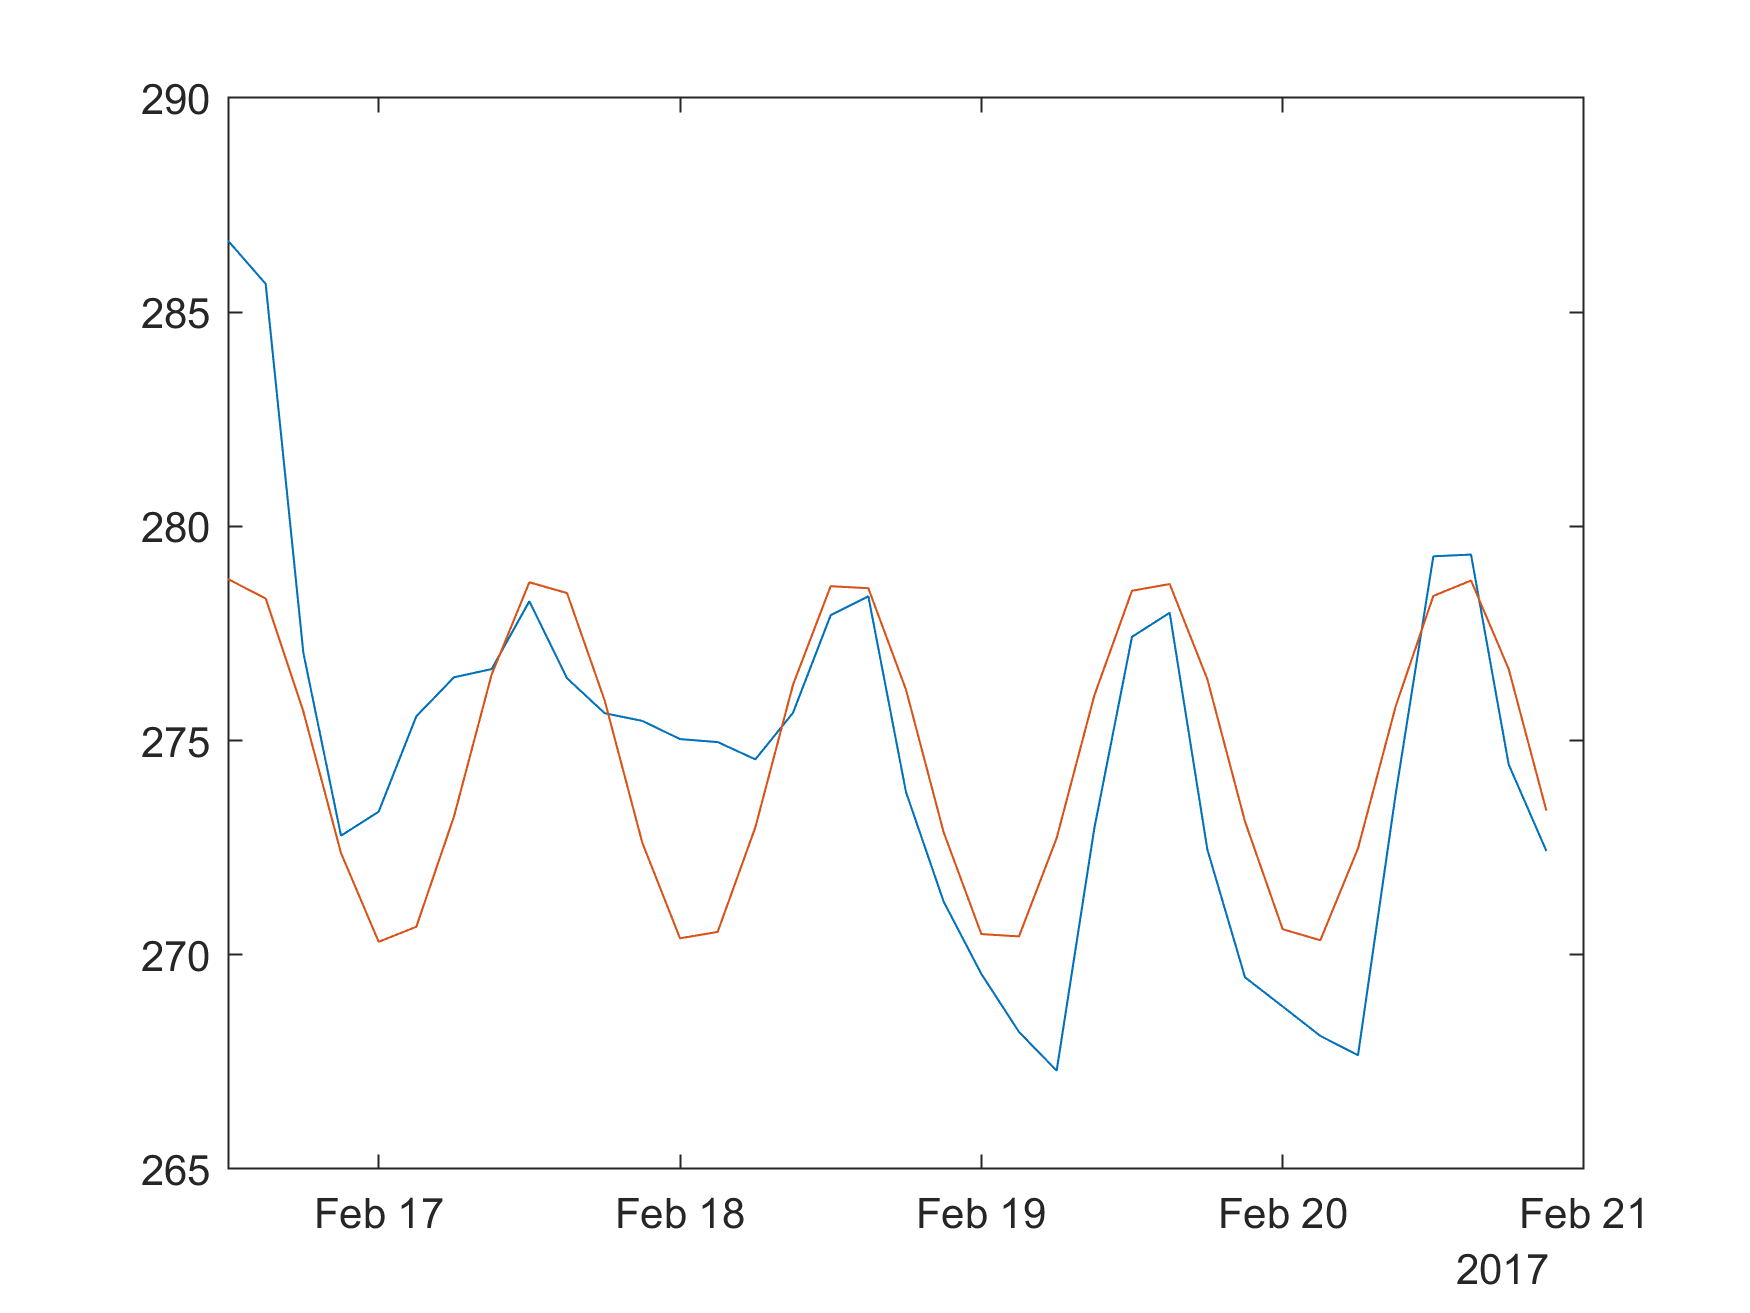

In [69]:
m.plot(dt,temp,dt,SineVal)
m.print(m.tempdir()+"sine2.png",'-dpng','-r300',nargout=0)
m.close(m.gcf())
Image(m.tempdir()+"sine2.png")

In [ ]:
m.quit()

#### Sine Fit 2: retrieve only the parameters
This second implementation does a minimal work from the MATLAB side, of fitting the parameters _(a,b,c,d)_ of the Sine model:

$a + b * \sin(2*\pi*c + d)$


In [90]:
# need to grab the first element of the matlab double array, to return a list
SineP = SineParams[0]
SineP

matlab.double([274.51842044220115,4.390270295890297,0.12378139169121775,1.3187000578012196,9.61367024285807])

In [77]:
from math import sin,pi 
# SineP(1)+SineP(2)*sin(2*pi*SineP(3)*tt+SineP(4)));
def Sine(t):
    return SineP[0]+SineP[1]*sin(2*pi*SineP[2]*t+SineP[3])

In [79]:
# generate a list from 1 to 40
t = list(range(1,41))
Sine(t[0])

278.3160060160971

In [92]:
# need to use the concept of list comprehension in Python to generate a list of Sine values
SineFit = [ Sine(x) for x in t ]
SineFit

[278.3160060160971,
 275.67847973668944,
 272.3739196764843,
 270.3024469769646,
 270.65515788048975,
 273.2292437128614,
 276.544605816173,
 278.69491187707507,
 278.4437364917198,
 275.93550543880036,
 272.6124508958369,
 270.3853283268998,
 270.53473260719556,
 272.9747563159341,
 276.3023864800646,
 278.6042366545825,
 278.5567436112691,
 276.1872158371935,
 272.85813116202854,
 270.4837123742306,
 270.4292496350409,
 272.7260590047737,
 276.0534757165994,
 278.4982360605309,
 278.6546034995617,
 276.432666798511,
 273.11003895995225,
 270.5972300930384,
 270.3391046170991,
 272.48408461103503,
 275.79880715806433,
 278.37730768952696,
 278.73694909673236,
 276.670937667739,
 273.3672294158298,
 270.72545569294766,
 270.2646356757483,
 272.24974074957385,
 275.539336033496,
 278.2419051283501]

In [81]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['current_time'], y=data['temp'],
                    mode='markers',
                    name='Temperatures'))
fig.add_trace(go.Scatter(x=data['current_time'], y=SineFit,
                    mode='lines',
                    name='SineFit'))

fig.show()